<a href="https://colab.research.google.com/github/SquareGraph/imaging-1d-data/blob/main/02_TS_I_Transfer_learning_on_Markov_and_Gramian_transormations_of_FordA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The evaluation of Time Series Imaging - transfer learning & well known models

In addition to the previous [notebook](https://github.com/SquareGraph/imaging-1d-data/blob/main/02_TS_I_Transfer_learning_on_Markov_and_Gramian_transormations_of_FordA_Dataset.ipynb) following is an enhancment.

Below you can find
>1. Downloading and preprocessing FordA dataset (GASF & Markov Transition Field)
>2. Building models from pretrained & well known architectures like:
<br>a) Resnet101 
<br>b) InceptionV3 
>3. Fitting models on datasets.
>4. Comparing them.



#1. Downloading datasets

In [ ]:
!wget https://www.timeseriesclassification.com/Downloads/FordA.zip

--2022-10-18 14:13:21--  https://www.timeseriesclassification.com/Downloads/FordA.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36365254 (35M) [application/zip]
Saving to: ‘FordA.zip.5’

FordA.zip.5         100%[===================>]  34.68M  20.9MB/s    in 1.7s    

2022-10-18 14:13:23 (20.9 MB/s) - ‘FordA.zip.5’ saved [36365254/36365254]



In [ ]:
!unzip /content/FordA.zip #unzipping to to the working directory

Archive:  /content/FordA.zip
replace FordA.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#Let's build a simple function that will extract features and labels from the text files. Also we want to turn classess into one_hot vector
import numpy as np
import tensorflow as tf

def read_file_to_xy(filepath: str):
    """
    Opens a text file from Ford Dataset, and split data into X & y for supervised learning problems.

    Returns: tuple(X,y)
    """
    with open(filepath, "r") as f:
        train_set = f.readlines()

    X = np.asarray([datapoint.split()[1:] for datapoint in train_set]).astype(np.float32)
    y = np.asarray([datapoint.split()[0] for datapoint in train_set]).astype(np.float32)

    y[y == -1] = 0 #labels were -1 and 1, so for the sigmoid activation we need values from 0 to 1.
    
    return X,y

In [ ]:
X_train_FordA, y_train_FordA = read_file_to_xy("/content/FordA_TRAIN.txt") #Train dataset
X_test_FordA, y_test_FordA = read_file_to_xy("/content/FordA_TEST.txt") #Test dataset

In [ ]:
X_train_FordA.shape, y_train_FordA.shape #checking if shapes matches

((3601, 500), (3601,))

In [ ]:
X_test_FordA.shape, y_test_FordA.shape #checking if shapes matches

((1320, 500), (1320,))

# 2. Imaging Time Series:

We'll build a function that will take our features data as an input, and return imaged features, according to the method we pick.

In [ ]:
!pip install pyts # colab doesn't come with Ppyts installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyts.image import MarkovTransitionField, GramianAngularField, RecurrencePlot
import matplotlib.pyplot as plt


# First we'll make a function to transform 1D data into two dimensional data.
# Next we'll use matplotlib to add a channel dimension instead of broadcasting shapes into black-and-white format


def transform_image_2D(features, method: str, 
                       bins: int=8,
                       markov_strategy: str='quantile',
                       gramian_method: str = 'summation',
                       sample_range: tuple =(-1,1),
                       size=1):

    """"
    Transforms a timeseries into image by one of the following method:

    method: "Gramian", "Markov", "Recurrence"
    size: Images will be square images of size  features.shape[1] x features.shape[1]

    For Markov Transition Field:

    bins: "size of the alphabet". Default 8.
    markove strategy: quantile, uniform or normal, for width of the bins. Default quantile

    For Gramian Angular field

    gramian_method: "summation" or "difference", methods of generating images
    sample_range: value range after transformation, tuple, default (0,1)

    For RecurrencePlot
    All the parameters will be default as defined here:
    https://pyts.readthedocs.io/en/0.10.0/auto_examples/image/plot_rp.html

    Returns: An array of shape features.shape[0], features.shape[1], features.shape[1]
    """

    image_size = np.round(features.shape[1]*size, decimals=1).astype(int)
    
    if method == "Markov": 

        method = MarkovTransitionField(image_size, n_bins=bins, strategy=markov_strategy)
        return method.fit_transform(features)

    elif method == "Gramian":

        method = GramianAngularField(image_size, sample_range=sample_range)
        return method.fit_transform(features)

    # elif method == "Recurrence":

    #     method = RecurrencePlot()
    #     return method.fit_transform(features)

    else:
        raise ValueError("Method should be equal to 'Markov','Gramian' or 'Recurrence'")

     

In [ ]:
# create three datasets, on default params, but with size reduction to save computing power. There is absolutely no need to go beyond image size bigger then 200px x 200px

X_train_FordA_Markov = transform_image_2D(X_train_FordA, method='Markov', size=0.35)
X_train_FordA_Gramian = transform_image_2D(X_train_FordA, method='Gramian', size=0.35)

In [ ]:
# And the same for test

X_test_FordA_Markov = transform_image_2D(X_test_FordA, method='Markov', size=0.35)
X_test_FordA_Gramian = transform_image_2D(X_test_FordA, method='Gramian', size=0.35)

In [ ]:
def turn_into_rgb(two_dim_img):

    """
    Takes 2D input, normalize it and "colorize" it through the matplotlib cmap
    """

    cmap = plt.cm.rainbow # could be any colour, but let's stick with a rainbow colors as in the Pyts documentation. Maybe it's a good idea how colormap with higher contrast affect the performance of Conv2D...
    norm = plt.Normalize(vmin=two_dim_img.min(), 
                     vmax=two_dim_img.max())
    
    return (cmap(norm(two_dim_img)))[:,:,:3] #Cmap adds also an alpha channel, but in this case and also for saving some computation power, we just want to get rid of the last alpha channel, that's why we slice.


def get_rgb_array(X_data_2d):
    return np.stack([turn_into_rgb(img2d) for img2d in X_data_2d])

In [ ]:
# Markov transformation follows:

train_fordA_rgb_markov = get_rgb_array(X_train_FordA_Markov) 
test_fordA_rgb_markov = get_rgb_array(X_test_FordA_Markov)

In [ ]:
# Gramian transformation follows:

train_fordA_rgb_gramian = get_rgb_array(X_train_FordA_Gramian)
test_fordA_rgb_gramian = get_rgb_array(X_test_FordA_Gramian)

In [ ]:
# now into tensorflow dataset
# If you don;t know those tricks, please read this article: https://www.tensorflow.org/guide/data_performance

def to_dataset(dataset_tuple, 
                batch=True, 
                batch_size=32, 
                cache=True, 
                prefetch=True):
    
    """
    Turns tuple of data into datasets
    """
    
    dataset = tf.data.Dataset.from_tensor_slices(dataset_tuple)
    dataset = dataset.batch(batch_size) if batch else dataset
    dataset = dataset.cache() if cache else dataset
    dataset = dataset.prefetch(tf.data.AUTOTUNE) if prefetch else dataset

    return dataset

In [ ]:
# Markov datasets

train_ds_markov = to_dataset((train_fordA_rgb_markov, y_train_FordA))
test_ds_markov = to_dataset((test_fordA_rgb_markov, y_test_FordA))

In [ ]:
# Gramian datasets

train_ds_gramian = to_dataset((train_fordA_rgb_gramian, y_train_FordA))
test_ds_gramian = to_dataset((test_fordA_rgb_gramian, y_test_FordA))

#3. Transfer Learning

In this approach we will train two pretrained architectures, on each of a dataset, and then extract some features, retrain on unfrozen layers. And compare results. 

We will use TF keras functional API with models from tf.keras.applications, with nearly all of the parameteres trainable.

> 1. We start from training trainable architectures of Resnet101 and Inception v3 on both of our datasets.
> 2. Second approach is to fit the same architectures, on the same datasets, but firstyl with frozen trainable parameters, and then to extract features, unfreeze some layers and retrain the architectures again.
> 3. As a last step we will make an inference with each model, to have some data that will help us compare results.

In [ ]:
#Mount drive for saving model checkpoints on my GDriv
from google.colab import drive
drive.mount("/content/gdrive")


# HYPERPARAMS

INPUT_SHAPE = train_fordA_rgb_markov[0].shape


#Download architecture
resnet_101 = tf.keras.applications.ResNet101(include_top=False, input_shape=INPUT_SHAPE)
inception_v3 = tf.keras.applications.InceptionV3(include_top=False, input_shape=INPUT_SHAPE)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def callbacks(model):
    return [tf.keras.callbacks.ReduceLROnPlateau(),
             tf.keras.callbacks.ModelCheckpoint(f"/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/{model.name}", save_best_only=True)]

In [ ]:
from tensorflow.keras import layers

def transfer_learning_model(applications_layer, name: str):

    inputs = layers.Input(shape=INPUT_SHAPE)
    custom = applications_layer(inputs)
    flatten = layers.Flatten()(custom)
    outputs = layers.Dense(1, activation="sigmoid")(flatten)

    model = tf.keras.Model(inputs, outputs, name=name)

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    model.summary()

    return model

### Trainining Inception v3 and Resnet_101 on Markov Transition Field Data

In [ ]:
resnet = transfer_learning_model(resnet_101, "resnet101")

Model: "resnet101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 1)                 73729     
                                                                 
Total params: 42,731,905
Trainable params: 42,626,561
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
inception_v3 = transfer_learning_model(inception_v3, "inception_v3")

Model: "inception_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 21,835,553
Trainable params: 21,801,121
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
resnet_history = resnet.fit(train_ds_markov, validation_data=test_ds_markov, 
                            epochs=40, callbacks=callbacks(resnet))

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 2.0700 - accuracy: 0.6437

113/113 [==============================] - 82s 531ms/step - loss: 2.0700 - accuracy: 0.6437 - val_loss: 1853475.1250 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 1.3285 - accuracy: 0.7006

113/113 [==============================] - 58s 514ms/step - loss: 1.3285 - accuracy: 0.7006 - val_loss: 1.0862 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.7570

113/113 [==============================] - 58s 518ms/step - loss: 0.5263 - accuracy: 0.7570 - val_loss: 0.7018 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - 10s 91ms/step - loss: 0.4074 - accuracy: 0.8056 - val_loss: 0.7685 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 5/40
113/113 [==============================] - 10s 90ms/step - loss: 0.3378 - accuracy: 0.8475 - val_loss: 1.0822 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - 10s 90ms/step - loss: 0.2719 - accuracy: 0.8764 - val_loss: 1.9362 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - 10s 90ms/step - loss: 0.2145 - accuracy: 0.9081 - val_loss: 1.6630 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 8/40
113/113 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9436

113/113 [==============================] - 57s 512ms/step - loss: 0.1513 - accuracy: 0.9436 - val_loss: 0.6809 - val_accuracy: 0.6508 - lr: 0.0010
Epoch 9/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0876 - accuracy: 0.9706 - val_loss: 2.0831 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 10/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0681 - accuracy: 0.9778 - val_loss: 4.2201 - val_accuracy: 0.5273 - lr: 0.0010
Epoch 11/40
113/113 [==============================] - 10s 90ms/step - loss: 0.0825 - accuracy: 0.9700 - val_loss: 0.6931 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 12/40
113/113 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9795

113/113 [==============================] - 58s 514ms/step - loss: 0.0614 - accuracy: 0.9795 - val_loss: 0.4470 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 13/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0605 - accuracy: 0.9786 - val_loss: 1.8245 - val_accuracy: 0.7114 - lr: 0.0010
Epoch 14/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0495 - accuracy: 0.9797 - val_loss: 0.6468 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 15/40
113/113 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9861

113/113 [==============================] - 58s 514ms/step - loss: 0.0430 - accuracy: 0.9861 - val_loss: 0.4158 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 16/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0215 - accuracy: 0.9947 - val_loss: 0.4670 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 17/40
113/113 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9939

113/113 [==============================] - 58s 520ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.3800 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 18/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.7276 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 19/40
113/113 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992

113/113 [==============================] - 58s 513ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.3347 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 20/40
113/113 [==============================] - 10s 91ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3531 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 21/40
113/113 [==============================] - 10s 92ms/step - loss: 2.0463e-04 - accuracy: 1.0000 - val_loss: 0.3702 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 22/40
113/113 [==============================] - 10s 90ms/step - loss: 1.1893e-04 - accuracy: 1.0000 - val_loss: 0.3836 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 23/40
113/113 [==============================] - 10s 90ms/step - loss: 8.4757e-05 - accuracy: 1.0000 - val_loss: 0.3969 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 24/40
113/113 [==============================] - 10s 90ms/step - loss: 6.7230e-05 - accuracy: 1.0000 - val_loss: 0.4080 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 25/40
113/113 [==========================

In [ ]:
inception_v3_history = inception_v3.fit(train_ds_markov, validation_data=test_ds_markov, 
                            epochs=40, callbacks=callbacks(resnet))

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.8023

113/113 [==============================] - 56s 412ms/step - loss: 0.5124 - accuracy: 0.8023 - val_loss: 1.5661 - val_accuracy: 0.8023 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8845

113/113 [==============================] - 45s 397ms/step - loss: 0.2770 - accuracy: 0.8845 - val_loss: 0.3793 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 3/40
113/113 [==============================] - 7s 62ms/step - loss: 0.2208 - accuracy: 0.9147 - val_loss: 3914.5708 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - 7s 64ms/step - loss: 0.4915 - accuracy: 0.8506 - val_loss: 1320.6252 - val_accuracy: 0.4841 - lr: 0.0010
Epoch 5/40
113/113 [==============================] - 7s 62ms/step - loss: 0.4447 - accuracy: 0.8142 - val_loss: 0.8914 - val_accuracy: 0.4189 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - 7s 62ms/step - loss: 0.3471 - accuracy: 0.8442 - val_loss: 0.8446 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - 7s 62ms/step - loss: 0.2579 - accuracy: 0.8964 - val_loss: 0.6233 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 8/40
113/113 [==============================] - 7s 63ms/step 

113/113 [==============================] - 45s 398ms/step - loss: 0.0627 - accuracy: 0.9783 - val_loss: 0.3254 - val_accuracy: 0.9068 - lr: 1.0000e-04
Epoch 14/40
112/113 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9919

113/113 [==============================] - 44s 396ms/step - loss: 0.0313 - accuracy: 0.9919 - val_loss: 0.3080 - val_accuracy: 0.9129 - lr: 1.0000e-04
Epoch 15/40
113/113 [==============================] - 7s 63ms/step - loss: 0.0201 - accuracy: 0.9950 - val_loss: 0.3233 - val_accuracy: 0.9121 - lr: 1.0000e-04
Epoch 16/40
113/113 [==============================] - 7s 66ms/step - loss: 0.0129 - accuracy: 0.9972 - val_loss: 0.3507 - val_accuracy: 0.9106 - lr: 1.0000e-04
Epoch 17/40
113/113 [==============================] - 7s 62ms/step - loss: 0.0090 - accuracy: 0.9992 - val_loss: 0.3768 - val_accuracy: 0.9121 - lr: 1.0000e-04
Epoch 18/40
113/113 [==============================] - 7s 63ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.4022 - val_accuracy: 0.9114 - lr: 1.0000e-04
Epoch 19/40
113/113 [==============================] - 7s 63ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.4244 - val_accuracy: 0.9121 - lr: 1.0000e-04
Epoch 20/40
113/113 [=======================

### Training on Gramian Angular Field

In [ ]:
# Create new models for Gramian Angular Field data

resnet_gramian = transfer_learning_model(resnet_101, "resnet101_gramian")
inception_v3_gramian = transfer_learning_model(inception_v3, "inception_v3_gramian")

Model: "resnet101_gramian"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 73729     
                                                                 
Total params: 42,731,905
Trainable params: 42,626,561
Non-trainable params: 105,344
_________________________________________________________________
Model: "inception_v3_gramian"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

In [ ]:
resnet_history_gramian = resnet_gramian.fit(train_ds_gramian, validation_data=test_ds_gramian, 
                            epochs=40, callbacks=callbacks(resnet_gramian))

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 0.9339 - accuracy: 0.6623

113/113 [==============================] - 73s 546ms/step - loss: 0.9339 - accuracy: 0.6623 - val_loss: 67992.4688 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.7901

113/113 [==============================] - 58s 520ms/step - loss: 0.4857 - accuracy: 0.7901 - val_loss: 29.0966 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 3/40
113/113 [==============================] - 10s 91ms/step - loss: 0.3562 - accuracy: 0.8392 - val_loss: 70.4404 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8645

113/113 [==============================] - 58s 521ms/step - loss: 0.3188 - accuracy: 0.8645 - val_loss: 4.3399 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 5/40
113/113 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8853

113/113 [==============================] - 59s 524ms/step - loss: 0.2598 - accuracy: 0.8853 - val_loss: 0.5625 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - 10s 91ms/step - loss: 0.2195 - accuracy: 0.9081 - val_loss: 0.8695 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - 10s 92ms/step - loss: 0.1893 - accuracy: 0.9250 - val_loss: 0.9940 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 8/40
113/113 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9397

113/113 [==============================] - 59s 525ms/step - loss: 0.1541 - accuracy: 0.9397 - val_loss: 0.5574 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 9/40
113/113 [==============================] - 10s 91ms/step - loss: 0.1225 - accuracy: 0.9550 - val_loss: 0.5657 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 10/40
113/113 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9520

113/113 [==============================] - 59s 525ms/step - loss: 0.1161 - accuracy: 0.9520 - val_loss: 0.4306 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 11/40
113/113 [==============================] - 11s 93ms/step - loss: 0.1024 - accuracy: 0.9617 - val_loss: 3.1500 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 12/40
113/113 [==============================] - 10s 92ms/step - loss: 0.0962 - accuracy: 0.9631 - val_loss: 1.0628 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 13/40
113/113 [==============================] - 10s 92ms/step - loss: 0.0743 - accuracy: 0.9717 - val_loss: 7.9204 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 14/40
113/113 [==============================] - 10s 92ms/step - loss: 0.0732 - accuracy: 0.9745 - val_loss: 0.9167 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 15/40
113/113 [==============================] - 10s 90ms/step - loss: 0.0430 - accuracy: 0.9858 - val_loss: 1.3465 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 16/40
113/113 [==============================] - 10s 91ms

In [ ]:
incpv3_history_gramian = inception_v3_gramian.fit(train_ds_gramian, validation_data=test_ds_gramian, 
                            epochs=40, callbacks=callbacks(inception_v3_gramian))

Epoch 1/40
112/113 [============================>.] - ETA: 0s - loss: 0.6396 - accuracy: 0.6710

113/113 [==============================] - 63s 499ms/step - loss: 0.6392 - accuracy: 0.6718 - val_loss: 0.8424 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.7412

113/113 [==============================] - 53s 475ms/step - loss: 0.6041 - accuracy: 0.7412 - val_loss: 0.8017 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 3/40
112/113 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.7626

113/113 [==============================] - 54s 480ms/step - loss: 0.5848 - accuracy: 0.7634 - val_loss: 0.5376 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.8309

113/113 [==============================] - 54s 482ms/step - loss: 0.5390 - accuracy: 0.8309 - val_loss: 0.5309 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 5/40
112/113 [============================>.] - ETA: 0s - loss: 0.5125 - accuracy: 0.8527

113/113 [==============================] - 54s 483ms/step - loss: 0.5122 - accuracy: 0.8534 - val_loss: 0.4937 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8764

113/113 [==============================] - 54s 484ms/step - loss: 0.4824 - accuracy: 0.8764 - val_loss: 0.4652 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8845

113/113 [==============================] - 54s 480ms/step - loss: 0.4656 - accuracy: 0.8845 - val_loss: 0.4476 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 8/40
112/113 [============================>.] - ETA: 0s - loss: 0.4637 - accuracy: 0.8730

113/113 [==============================] - 55s 488ms/step - loss: 0.4632 - accuracy: 0.8736 - val_loss: 0.4474 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 9/40
113/113 [==============================] - 7s 64ms/step - loss: 0.4466 - accuracy: 0.8817 - val_loss: 0.6763 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 10/40
112/113 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.9046

113/113 [==============================] - 54s 484ms/step - loss: 0.4142 - accuracy: 0.9050 - val_loss: 0.4469 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 11/40
112/113 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.9062

113/113 [==============================] - 54s 482ms/step - loss: 0.4039 - accuracy: 0.9067 - val_loss: 0.4364 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 12/40
112/113 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8761

113/113 [==============================] - 55s 491ms/step - loss: 0.4267 - accuracy: 0.8767 - val_loss: 0.4037 - val_accuracy: 0.8894 - lr: 0.0010
Epoch 13/40
113/113 [==============================] - 7s 66ms/step - loss: 0.4375 - accuracy: 0.8625 - val_loss: 0.9035 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 14/40
113/113 [==============================] - 8s 68ms/step - loss: 0.4514 - accuracy: 0.8467 - val_loss: 0.5725 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 15/40
113/113 [==============================] - 7s 63ms/step - loss: 0.4299 - accuracy: 0.8667 - val_loss: 0.5882 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 16/40
112/113 [============================>.] - ETA: 0s - loss: 0.3882 - accuracy: 0.8954

113/113 [==============================] - 54s 485ms/step - loss: 0.3876 - accuracy: 0.8959 - val_loss: 0.3816 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 17/40
113/113 [==============================] - 7s 65ms/step - loss: 0.3487 - accuracy: 0.9211 - val_loss: 0.6777 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 18/40
113/113 [==============================] - 8s 68ms/step - loss: 0.3277 - accuracy: 0.9353 - val_loss: 0.5629 - val_accuracy: 0.7652 - lr: 0.0010
Epoch 19/40
113/113 [==============================] - 7s 63ms/step - loss: 0.3183 - accuracy: 0.9350 - val_loss: 0.3877 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 20/40
113/113 [==============================] - 7s 63ms/step - loss: 0.3048 - accuracy: 0.9389 - val_loss: 0.4601 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 21/40
112/113 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.9467

113/113 [==============================] - 54s 485ms/step - loss: 0.2909 - accuracy: 0.9470 - val_loss: 0.3328 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 22/40
113/113 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.9450

113/113 [==============================] - 54s 485ms/step - loss: 0.2828 - accuracy: 0.9450 - val_loss: 0.3145 - val_accuracy: 0.9182 - lr: 0.0010
Epoch 23/40
113/113 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9483

113/113 [==============================] - 55s 487ms/step - loss: 0.2725 - accuracy: 0.9483 - val_loss: 0.3139 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 24/40
113/113 [==============================] - 7s 64ms/step - loss: 0.2651 - accuracy: 0.9522 - val_loss: 0.6927 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 25/40
113/113 [==============================] - 8s 68ms/step - loss: 0.2755 - accuracy: 0.9411 - val_loss: 0.3325 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 26/40
113/113 [==============================] - 7s 65ms/step - loss: 0.2448 - accuracy: 0.9570 - val_loss: 0.3155 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 27/40
113/113 [==============================] - 7s 64ms/step - loss: 0.2400 - accuracy: 0.9570 - val_loss: 0.3320 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 28/40
113/113 [==============================] - 7s 64ms/step - loss: 0.2423 - accuracy: 0.9536 - val_loss: 0.5503 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 29/40
113/113 [==============================] - ETA: 0s - los

113/113 [==============================] - 54s 484ms/step - loss: 0.2331 - accuracy: 0.9531 - val_loss: 0.2990 - val_accuracy: 0.9121 - lr: 0.0010
Epoch 30/40
113/113 [==============================] - 7s 64ms/step - loss: 0.2401 - accuracy: 0.9492 - val_loss: 0.9200 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 31/40
113/113 [==============================] - 8s 67ms/step - loss: 0.2270 - accuracy: 0.9542 - val_loss: 0.3862 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 32/40
113/113 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9595

113/113 [==============================] - 55s 492ms/step - loss: 0.2137 - accuracy: 0.9595 - val_loss: 0.2779 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 33/40
113/113 [==============================] - 8s 67ms/step - loss: 0.2297 - accuracy: 0.9514 - val_loss: 0.2794 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 34/40
113/113 [==============================] - 7s 64ms/step - loss: 0.1976 - accuracy: 0.9658 - val_loss: 0.3339 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 35/40
113/113 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9700

113/113 [==============================] - 54s 478ms/step - loss: 0.1854 - accuracy: 0.9700 - val_loss: 0.2579 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 36/40
113/113 [==============================] - 7s 64ms/step - loss: 0.1944 - accuracy: 0.9617 - val_loss: 0.4875 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 37/40
113/113 [==============================] - 8s 69ms/step - loss: 0.1756 - accuracy: 0.9717 - val_loss: 0.2911 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 38/40
113/113 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9697

113/113 [==============================] - 55s 487ms/step - loss: 0.1773 - accuracy: 0.9697 - val_loss: 0.2509 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 39/40
113/113 [==============================] - 7s 65ms/step - loss: 0.1648 - accuracy: 0.9742 - val_loss: 0.2587 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 40/40
113/113 [==============================] - 8s 67ms/step - loss: 0.1484 - accuracy: 0.9825 - val_loss: 0.2722 - val_accuracy: 0.9197 - lr: 0.0010


# Markov Datasets approach with feature extraction from Resnet & Inception
Firstly we'll fit models with frozen params on our datasets.
Next we will unfreeze some layers, and retrain again, and compare results.

### Markov Transititon Field approach

> 1. We'll start with Resnet
> 2. Inception v3 follows

#### Resnet 101

In [ ]:
resnet_101_frozen = tf.keras.applications.ResNet101(include_top=False, input_shape=INPUT_SHAPE)
resnet_101_frozen.trainable = False
resnet_frozen_markov = transfer_learning_model(resnet_101_frozen, "resnet101_frozen_markov")

Model: "resnet101_frozen_markov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 73729     
                                                                 
Total params: 42,731,905
Trainable params: 73,729
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:
resnet_frozen_history_markov = resnet_frozen_markov.fit(train_ds_markov, 
                                                        validation_data=test_ds_markov, 
                                                        epochs=40, callbacks=callbacks(resnet_frozen_markov))

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 1.1862 - accuracy: 0.5754

113/113 [==============================] - 57s 449ms/step - loss: 1.1862 - accuracy: 0.5754 - val_loss: 0.5993 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6482

113/113 [==============================] - 48s 426ms/step - loss: 0.7601 - accuracy: 0.6482 - val_loss: 0.5638 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 3/40
113/113 [==============================] - 5s 40ms/step - loss: 0.8031 - accuracy: 0.6570 - val_loss: 0.6456 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.6470

113/113 [==============================] - 48s 431ms/step - loss: 0.8457 - accuracy: 0.6470 - val_loss: 0.5632 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 5/40
113/113 [==============================] - 5s 40ms/step - loss: 0.7097 - accuracy: 0.6912 - val_loss: 0.5740 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.6873

113/113 [==============================] - 47s 423ms/step - loss: 0.7247 - accuracy: 0.6873 - val_loss: 0.5541 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7095

113/113 [==============================] - 48s 429ms/step - loss: 0.6603 - accuracy: 0.7095 - val_loss: 0.5520 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 8/40
113/113 [==============================] - 5s 40ms/step - loss: 0.6733 - accuracy: 0.7117 - val_loss: 0.5534 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 9/40
113/113 [==============================] - 5s 40ms/step - loss: 0.6679 - accuracy: 0.7148 - val_loss: 0.5536 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 10/40
113/113 [==============================] - 5s 40ms/step - loss: 0.6684 - accuracy: 0.7151 - val_loss: 0.5603 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 11/40
113/113 [==============================] - 4s 40ms/step - loss: 0.6986 - accuracy: 0.7056 - val_loss: 0.5658 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 12/40
113/113 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.7329

113/113 [==============================] - 48s 428ms/step - loss: 0.6217 - accuracy: 0.7329 - val_loss: 0.5500 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 13/40
113/113 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.7354

113/113 [==============================] - 48s 431ms/step - loss: 0.6171 - accuracy: 0.7354 - val_loss: 0.5448 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 14/40
113/113 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7367

113/113 [==============================] - 47s 423ms/step - loss: 0.6000 - accuracy: 0.7367 - val_loss: 0.5430 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 15/40
113/113 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.7379

113/113 [==============================] - 48s 428ms/step - loss: 0.5947 - accuracy: 0.7379 - val_loss: 0.5428 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 16/40
113/113 [==============================] - 5s 40ms/step - loss: 0.5910 - accuracy: 0.7426 - val_loss: 0.5433 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 17/40
113/113 [==============================] - 5s 40ms/step - loss: 0.5870 - accuracy: 0.7437 - val_loss: 0.5440 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 18/40
113/113 [==============================] - 5s 40ms/step - loss: 0.5829 - accuracy: 0.7442 - val_loss: 0.5448 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 19/40
113/113 [==============================] - 4s 40ms/step - loss: 0.5789 - accuracy: 0.7478 - val_loss: 0.5456 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 20/40
113/113 [==============================] - 4s 40ms/step - loss: 0.5750 - accuracy: 0.7481 - val_loss: 0.5465 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 21/40
113/113 [==============================] - 4s 40ms/step 

113/113 [==============================] - 48s 424ms/step - loss: 0.3862 - accuracy: 0.8250 - val_loss: 0.5349 - val_accuracy: 0.7568 - lr: 1.0000e-05
Epoch 37/40
113/113 [==============================] - 5s 40ms/step - loss: 0.3841 - accuracy: 0.8264 - val_loss: 0.5349 - val_accuracy: 0.7568 - lr: 1.0000e-05
Epoch 38/40
113/113 [==============================] - 4s 40ms/step - loss: 0.3840 - accuracy: 0.8267 - val_loss: 0.5350 - val_accuracy: 0.7553 - lr: 1.0000e-05
Epoch 39/40
113/113 [==============================] - 5s 40ms/step - loss: 0.3839 - accuracy: 0.8275 - val_loss: 0.5352 - val_accuracy: 0.7553 - lr: 1.0000e-05
Epoch 40/40
113/113 [==============================] - 4s 40ms/step - loss: 0.3839 - accuracy: 0.8278 - val_loss: 0.5355 - val_accuracy: 0.7538 - lr: 1.0000e-05


#### Inception v3

In [ ]:
inception_v3_frozen = tf.keras.applications.InceptionV3(include_top=False, input_shape=INPUT_SHAPE)
inception_v3_frozen.trainable = False
inception_v3_frozen_markov = transfer_learning_model(inception_v3_frozen, "inception_v3_frozen_markov")

Model: "inception_v3_frozen_markov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 175, 175, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 21,835,553
Trainable params: 32,769
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception_v3_frozen_history_markov = inception_v3_frozen_markov.fit(train_ds_markov, 
                                                        validation_data=test_ds_markov, 
                                                        epochs=40, callbacks=callbacks(inception_v3_frozen_markov))

Epoch 1/40
112/113 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6783

113/113 [==============================] - 44s 357ms/step - loss: 0.6668 - accuracy: 0.6784 - val_loss: 0.5426 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 2/40
113/113 [==============================] - 3s 27ms/step - loss: 0.4572 - accuracy: 0.7831 - val_loss: 0.5501 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 3/40
113/113 [==============================] - 3s 28ms/step - loss: 0.3705 - accuracy: 0.8412 - val_loss: 0.5733 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 4/40
113/113 [==============================] - 3s 28ms/step - loss: 0.3402 - accuracy: 0.8528 - val_loss: 0.5927 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 5/40
113/113 [==============================] - 3s 29ms/step - loss: 0.3597 - accuracy: 0.8495 - val_loss: 0.7799 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 6/40
113/113 [==============================] - 3s 28ms/step - loss: 0.3718 - accuracy: 0.8550 - val_loss: 0.6702 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 7/40
113/113 [==============================] - 3s 28ms/step - loss

### Unfreeze layers for Markov models

In [ ]:
resnet_101_frozen.trainable = True

for layer in resnet_101_frozen.layers[:-40]:
    layer.trainable = False

In [ ]:
resnet_101_frozen.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

resnet_101_frozen.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 175, 175, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 181, 181, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 88, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 88, 64)   256         ['conv1_conv[0][0]']     

In [ ]:
resnet_frozen_history_markov = resnet_frozen_markov.fit(train_ds_markov, 
                                                        initial_epoch=40,
                                                        validation_data=test_ds_markov, 
                                                        epochs=80, callbacks=callbacks(resnet_frozen_markov))

Epoch 41/80
113/113 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8284

113/113 [==============================] - 48s 427ms/step - loss: 0.3839 - accuracy: 0.8284 - val_loss: 0.5357 - val_accuracy: 0.7530 - lr: 1.0000e-05
Epoch 42/80
113/113 [==============================] - 5s 40ms/step - loss: 0.3838 - accuracy: 0.8287 - val_loss: 0.5360 - val_accuracy: 0.7515 - lr: 1.0000e-05
Epoch 43/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3838 - accuracy: 0.8295 - val_loss: 0.5363 - val_accuracy: 0.7530 - lr: 1.0000e-05
Epoch 44/80
113/113 [==============================] - 5s 40ms/step - loss: 0.3838 - accuracy: 0.8284 - val_loss: 0.5366 - val_accuracy: 0.7530 - lr: 1.0000e-05
Epoch 45/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3837 - accuracy: 0.8281 - val_loss: 0.5369 - val_accuracy: 0.7523 - lr: 1.0000e-05
Epoch 46/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3837 - accuracy: 0.8275 - val_loss: 0.5371 - val_accuracy: 0.7515 - lr: 1.0000e-05
Epoch 47/80
113/113 [=======================

113/113 [==============================] - 48s 432ms/step - loss: 0.3813 - accuracy: 0.8278 - val_loss: 0.5245 - val_accuracy: 0.7621 - lr: 1.0000e-06
Epoch 53/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3795 - accuracy: 0.8270 - val_loss: 0.5245 - val_accuracy: 0.7629 - lr: 1.0000e-06
Epoch 54/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3795 - accuracy: 0.8270 - val_loss: 0.5245 - val_accuracy: 0.7621 - lr: 1.0000e-06
Epoch 55/80
113/113 [==============================] - 5s 40ms/step - loss: 0.3795 - accuracy: 0.8270 - val_loss: 0.5245 - val_accuracy: 0.7621 - lr: 1.0000e-06
Epoch 56/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3795 - accuracy: 0.8270 - val_loss: 0.5245 - val_accuracy: 0.7621 - lr: 1.0000e-06
Epoch 57/80
113/113 [==============================] - 4s 40ms/step - loss: 0.3795 - accuracy: 0.8270 - val_loss: 0.5246 - val_accuracy: 0.7621 - lr: 1.0000e-06
Epoch 58/80
113/113 [=======================

113/113 [==============================] - 48s 426ms/step - loss: 0.3786 - accuracy: 0.8306 - val_loss: 0.5244 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 64/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8295

113/113 [==============================] - 49s 435ms/step - loss: 0.3785 - accuracy: 0.8295 - val_loss: 0.5243 - val_accuracy: 0.7614 - lr: 1.0000e-07
Epoch 65/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8289

113/113 [==============================] - 48s 426ms/step - loss: 0.3785 - accuracy: 0.8289 - val_loss: 0.5242 - val_accuracy: 0.7614 - lr: 1.0000e-07
Epoch 66/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8281

113/113 [==============================] - 48s 431ms/step - loss: 0.3785 - accuracy: 0.8281 - val_loss: 0.5242 - val_accuracy: 0.7614 - lr: 1.0000e-07
Epoch 67/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 49s 433ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 68/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 426ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 69/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 49s 438ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 70/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 431ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 71/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 431ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 72/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 425ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 73/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 428ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 74/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 48s 431ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 75/80
113/113 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8278

113/113 [==============================] - 49s 436ms/step - loss: 0.3785 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-07
Epoch 76/80
113/113 [==============================] - 5s 41ms/step - loss: 0.3783 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-08
Epoch 77/80
113/113 [==============================] - 5s 41ms/step - loss: 0.3783 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-08
Epoch 78/80
113/113 [==============================] - 5s 41ms/step - loss: 0.3783 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-08
Epoch 79/80
113/113 [==============================] - 5s 41ms/step - loss: 0.3783 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-08
Epoch 80/80
113/113 [==============================] - 5s 41ms/step - loss: 0.3783 - accuracy: 0.8278 - val_loss: 0.5242 - val_accuracy: 0.7621 - lr: 1.0000e-08


In [ ]:
inception_v3_frozen.trainable = True

for layer in inception_v3_frozen.layers[:-40]:
    layer.trainable = False

In [ ]:
inception_v3_frozen_markov.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

inception_v3_frozen_markov.summary()

Model: "inception_v3_frozen_markov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 175, 175, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 21,835,553
Trainable params: 6,106,497
Non-trainable params: 15,729,056
_________________________________________________________________


In [ ]:
inception_v3_frozen_history_markov = inception_v3_frozen_markov.fit(train_ds_markov, 
                                                                    initial_epoch=40, 
                                                                    validation_data=test_ds_markov, 
                                                                    epochs=80, 
                                                                    callbacks=callbacks(inception_v3_frozen_markov))

Epoch 41/80
112/113 [============================>.] - ETA: 0s - loss: 3.0548 - accuracy: 0.6772

113/113 [==============================] - 47s 373ms/step - loss: 3.0454 - accuracy: 0.6779 - val_loss: 1.5249 - val_accuracy: 0.6788 - lr: 0.0010
Epoch 42/80
111/113 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.8086

113/113 [==============================] - 39s 351ms/step - loss: 0.6807 - accuracy: 0.8098 - val_loss: 1.0571 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 43/80
113/113 [==============================] - 4s 32ms/step - loss: 0.2672 - accuracy: 0.9114 - val_loss: 1.4091 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 44/80
113/113 [==============================] - 4s 33ms/step - loss: 0.2724 - accuracy: 0.9231 - val_loss: 2.3708 - val_accuracy: 0.6871 - lr: 0.0010
Epoch 45/80
113/113 [==============================] - 4s 34ms/step - loss: 0.3950 - accuracy: 0.9086 - val_loss: 2.1125 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 46/80
113/113 [==============================] - 4s 33ms/step - loss: 0.4521 - accuracy: 0.8948 - val_loss: 2.1884 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 47/80
113/113 [==============================] - 4s 33ms/step - loss: 0.4612 - accuracy: 0.8945 - val_loss: 2.1962 - val_accuracy: 0.7015 - lr: 0.0010
Epoch 48/80
113/113 [==============================] - 4s 33ms/step 

### Gramian Angular Field approach

It should be here, but accordingly to the results of transfer learning above, it's not much help, so there is a little chance for improving the results of loss or accuracy. So, we will pass this stage, and progress to the Custom Conv Net.

In [ ]:
# resnet_frozen_gramian = transfer_learning_model(resnet_101_frozen, "resnet101_frozen_gramian")
# inception_v3_frozen_gramian = transfer_learning_model(inception_v3_frozen, "inception_v43frozen_gramian")

# 4. Scoring and comparing models

So, at this moment we have following models:
> 1. Trainable Resnet101 fitted on Gramian and Markov Data
> 2. Trainable Inception v3 fitted on Gramian and Markov Data
> 3. Feature extraction from Resnet101 fitted on Markov Data
> 4. Feature extraction from Inception v3 fitted on Markov Data

We discarded experiments on feature extraction, cause as seen on a Markov Data, it doesn't help anyway. So below, will draw some charts, to test and evaluate all the models.

In [ ]:
# Create function for scoring metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def score(y_true, y_preds):

    dict = {"acc": accuracy_score(y_true, y_preds),
            "precision": precision_score(y_true, y_preds, average='weighted'),
            "recall": recall_score(y_true, y_preds, average='weighted'),
            "f1_score": f1_score(y_true, y_preds, average='weighted')}

    return dict

In [ ]:
# MODELS
# resnet_history
# inception_v3_history
# resnet_history_gramian
# incpv3_history_gramian
# resnet_frozen_history_markov
# inception_v3_frozen_history_markov



In [ ]:
def predict_and_score(model, test_dataset):

    predictions = model.predict(test_dataset)

    return score(y_true, np.round(predictions)), predictions

y_true = y_test_FordA

In [ ]:
resnet_markov_loaded = tf.keras.models.load_model("/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/resnet101", compile=True)
inception_v3_markov_loaded = tf.keras.models.load_model("/content/gdrive/MyDrive/AI_ML/Experiments/TimeSeriesImaging/inception_v3", compile=True)

In [ ]:
# Resnet model on Markov and Gramian Datasets
markov_resnet_score, markov_resnet_preds = predict_and_score(resnet_markov_loaded, test_ds_markov)
gramian_resnet_score, markov_resnet_preds = predict_and_score(resnet_gramian, test_ds_gramian)

42/42 [==============================] - 1s 26ms/step


In [ ]:
# Inception v3 model on Markov and Gramian Datasets
markov_inc_v3_score, markov_inc_v3_preds = predict_and_score(inception_v3_markov_loaded, test_ds_markov)
gramian_inc_v3_score, markov_inc_v3_preds = predict_and_score(inception_v3_gramian, test_ds_gramian)

42/42 [==============================] - 1s 21ms/step


In [ ]:
markov_resnet_FE_score, markov_resnet_FE_preds = predict_and_score(resnet_frozen_markov, test_ds_markov)
markov_inc_v3_FE_score, markov_inc_v3_FE_preds = predict_and_score(inception_v3_frozen_markov, test_ds_markov)

42/42 [==============================] - 1s 21ms/step


In [ ]:
import pandas as pd

pd.DataFrame({"Markov Resnet":markov_resnet_score, 
              "Gramian Resnet":gramian_resnet_score, 
              "Markov Inception v3":markov_inc_v3_score, 
              "Gramian Inception v3":gramian_inc_v3_score, 
              "Markov FE Resnet":markov_resnet_FE_score,
              "Markov FE Inception v3":markov_inc_v3_FE_score})

,Markov Resnet,Gramian Resnet,Markov Inception v3,Gramian Inception v3,Markov FE Resnet,Markov FE Inception v3
acc,0.912879,0.923485,0.907576,0.919697,0.762121,0.750000
precision,0.913224,0.923759,0.912471,0.921409,0.762193,0.750255
recall,0.912879,0.923485,0.907576,0.919697,0.762121,0.750000
f1_score,0.912900,0.923503,0.907117,0.919522,0.761904,0.749628


In [ ]:
loss = resnet_history_gramian.history["loss"]
acc = resnet_history_gramian.history["accuracy"]
val_loss = resnet_history_gramian.history["val_loss"]
val_acc = resnet_history_gramian.history["val_accuracy"]
epochs_count = np.arange(0,40)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

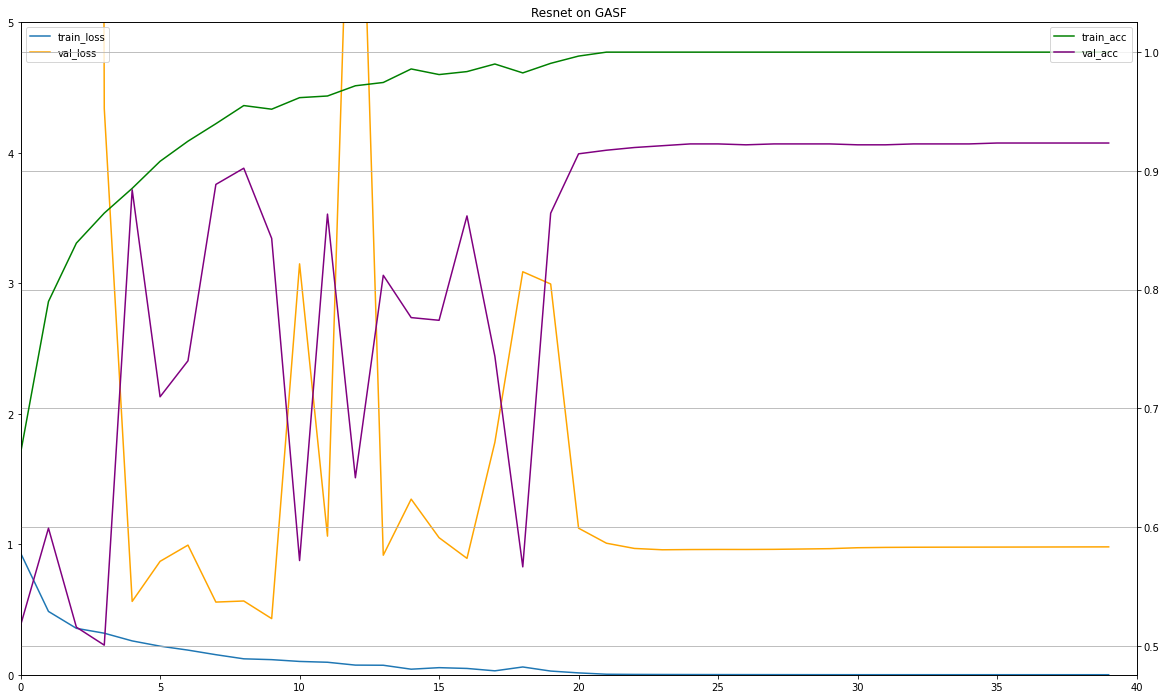

In [ ]:
#And let's plot the best solution

fig,ax = plt.subplots(figsize=(20,12))
plt.title("Resnet on GASF")
ax.plot(epochs_count, loss, label="train_loss")
ax.plot(epochs_count, val_loss, label="val_loss", c="orange")
ax.set(xlim=(0, 40), ylim=(0, 5))

ax1 = ax.twinx()

ax1.plot(epochs_count, acc, label="train_acc", c="green")
ax1.plot(epochs_count, val_acc, label="val_acc", c="purple")

ax.legend(loc="upper left")
ax1.legend(loc="upper right")

plt.grid()
plt.show()

#6. Final thoughts

> 1. Transfer Learninig with feature extraction isn't great help
> 2. Using well-known architectures looks promising, but they need to be trained over 40 epochs, as only after 30 epochs their curves of learning (loss and accuracy) are becoming stable, so they are not struggling with generalization.